In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import signal
import matplotlib.pyplot as plt
import peakutils
import math

In [60]:
rt_l = []
rt_l.append((1,12))
rt_l.append((2,16))
rt_l.append((3,15))
rt_l.append((4,20))
rt_l.append((5,22))
rt_l.append((6,24))
rt_l.append((7,27))
rt_l.append((8,30))
rt_l.append((9,28))
rt_l.append((10,24))
rt_l.append((11,18))
rt_l.append((12,16))
rt_l.append((13,12))
rt_l.append((14,8))
rt_l.append((15,6))
rt_l.append((16,15))
rt_l.append((17,23))
rt_l.append((18,32))
rt_l.append((19,36))
rt_l.append((20,18))
rt_l.append((21,20))
rt_l.append((22,21))
rt_l.append((23,23))
rt_l.append((24,26))
rt_l.append((25,30))

In [61]:
rt_df = pd.DataFrame(rt_l, columns=['retention_time_secs','intensity'])
rt_df['filtered_intensity'] = rt_df.intensity

In [62]:
window_length = 11
estimated_peak_width = 20

In [63]:
rt_df['filtered_intensity'] = signal.savgol_filter(rt_df.intensity, window_length=window_length, polyorder=3)

In [64]:
rt_df['x'] = rt_df.retention_time_secs

In [65]:
peak_idxs = peakutils.indexes(rt_df.filtered_intensity.values, thres=0.05, min_dist=estimated_peak_width/4, thres_abs=False)
peak_x_l = rt_df.iloc[peak_idxs].x.to_list()

In [66]:
if len(peak_x_l) == 0:
    print('could not find any peaks - taking the maximum point')
    # get the maximum intensity point
    peak_x_l = [int(rt_df.loc[rt_df.filtered_intensity.idxmax()].x)]

In [67]:
peaks_df = rt_df[rt_df.x.isin(peak_x_l)]

In [68]:
peaks_df

,retention_time_secs,intensity,filtered_intensity,x
7,8,30,27.305361,8
19,20,18,25.780886,20


In [69]:
valley_idxs = peakutils.indexes(-rt_df.filtered_intensity.values, thres=0.5, min_dist=estimated_peak_width/4, thres_abs=False)
valley_x_l = rt_df.iloc[valley_idxs].x.to_list()
valleys_df = rt_df[rt_df.x.isin(valley_x_l)]

In [70]:
valleys_df

,retention_time_secs,intensity,filtered_intensity,x
13,14,8,10.179487,14
22,23,23,20.668998,23


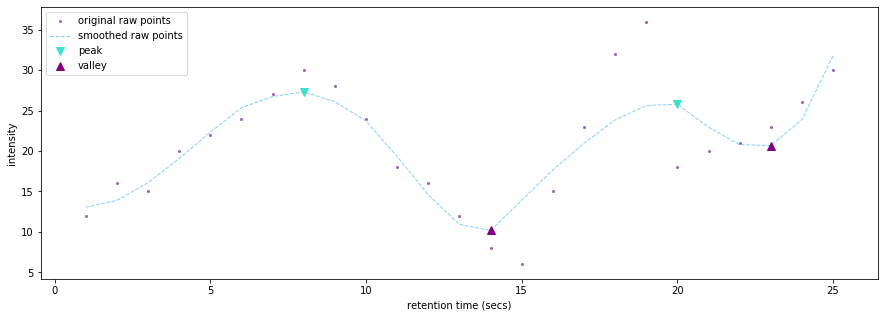

In [71]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_df.x, rt_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_df.x, rt_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# show the peaks
if len(peaks_df) > 0:
    ax.plot(peaks_df.x, peaks_df.filtered_intensity, marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
# show the valleys
if len(valleys_df) > 0:
    ax.plot(valleys_df.x, valleys_df.filtered_intensity, marker='^', color='purple', linestyle='', markeredgewidth=1, ms=8, label='valley')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.show()

In [72]:
# extract the points belonging to each isolated peak
peaks_l = []
for peak in peaks_df.itertuples():
    # find the x bounds
    upper_x = valleys_df[valleys_df.x > peak.x].x.min()
    if math.isnan(upper_x):
        upper_x = rt_df.x.max()
    lower_x = valleys_df[valleys_df.x < peak.x].x.max()
    if math.isnan(lower_x):
        lower_x = rt_df.x.min()
    # find the standard deviation and FWHM, assuming a gaussian distribution
    std_dev = np.mean([abs(peak.x-upper_x), abs(peak.x-lower_x)]) / 3
    fwhm = 2.355 * std_dev
    peaks_l.append((peak.x, peak.intensity, lower_x, upper_x, std_dev, fwhm))
isolated_peaks_df = pd.DataFrame(peaks_l, columns=['peak_x','intensity','lower_x','upper_x','std_dev','fwhm'])

In [73]:
isolated_peaks_df

,peak_x,intensity,lower_x,upper_x,std_dev,fwhm
0,8,30,1,14,2.166667,5.1025
1,20,18,14,23,1.500000,3.5325


In [74]:
peak_x_l = rt_df.iloc[peak_idxs].x.to_list()
peak_x_l

[8, 20]

In [75]:
peak_x_l = [int(rt_df.loc[rt_df.filtered_intensity.idxmax()].x)]
peak_x_l

[25]

In [76]:
valley_x_l = [rt_df.x.min(), rt_df.x.max()]
valley_x_l

[1, 25]

In [77]:
# the x-axis value for each peak
peak_x_l = [int(rt_df.loc[rt_df.filtered_intensity.idxmax()].x)]
peak_x_l

[25]